In [10]:
import pandas as pd
import os
import sys
import torch

In [11]:
# --- To Import Modules from src ---
try:
    notebook_dir = os.path.dirname(os.path.abspath(__file__)) 
except NameError:
    notebook_dir = os.path.abspath('.') 

project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

if project_root not in sys.path:
    print(f"Adding {project_root} to sys.path")
    sys.path.insert(0, project_root)

## 1. Load Dataframes

In [12]:
def load_and_display(file_path, df_name):
    print(f"\n--------------------- Loading '{os.path.basename(file_path)}' ---------------------")
    try:
        df = pd.read_parquet(file_path)
        print(f"Successfully loaded {len(df)} rows into '{df_name}'.")
        df_counts = df['rating'].value_counts()
        df_counts = df_counts.sort_index()
        print(df_counts)
        print(df.head())
        return df
    except FileNotFoundError:
        print(f"ERROR: File not found at {file_path}", file=sys.stderr)
        return None
    except Exception as e:
        print(f"ERROR: Failed to load {os.path.basename(file_path)}: {e}", file=sys.stderr)
        return None

In [13]:
processed_data_dir = '../data/processed/'

interactions_filename = 'interactions.parquet' 
positive_interactions_filename = 'positive_interactions.parquet' 
negative_interactions_filename = 'negative_interactions.parquet' 

interactions_path = os.path.join(processed_data_dir, interactions_filename)
positive_interactions_path = os.path.join(processed_data_dir, positive_interactions_filename)
negative_interactions_path = os.path.join(processed_data_dir, negative_interactions_filename)


interactions_df = load_and_display(interactions_path, 'interactions_df')
positive_interactions_df = load_and_display(positive_interactions_path, 'positive_interactions_df')
negative_interactions_df = load_and_display(negative_interactions_path, 'negative_interactions_df')


--------------------- Loading 'interactions.parquet' ---------------------
Successfully loaded 15739967 rows into 'interactions_df'.
rating
0     551885
1     448016
2    1107096
3    3117525
4    5250205
5    5265240
Name: count, dtype: int64
                            user_id   book_id  rating  user_idx  item_idx
0  8842281e1d1347389f2ab93d60773d4d  24375664       5         0         0
1  8842281e1d1347389f2ab93d60773d4d  18245960       5         0         1
2  8842281e1d1347389f2ab93d60773d4d   6392944       3         0         2
3  8842281e1d1347389f2ab93d60773d4d  22078596       4         0         3
4  8842281e1d1347389f2ab93d60773d4d   6644782       4         0         4

--------------------- Loading 'positive_interactions.parquet' ---------------------
Successfully loaded 10515445 rows into 'positive_interactions_df'.
rating
4    5250205
5    5265240
Name: count, dtype: int64
                            user_id   book_id  rating  user_idx  item_idx
0  8842281e1d1347389f2ab93

## 2. Construct Interaction Graph (Only Positive Interactions)

In [ ]:
n_users_positive = positive_interactions_df['user_idx'].nunique()
n_items_positive = positive_interactions_df['item_idx'].nunique()

print(f"\nUnique users in positive interactions: {n_users_positive}")
print(f"Unique items in positive interactions: {n_items_positive}")


Unique users in positive interactions: 429772
Unique items in positive interactions: 1589256


In [15]:
# Extract user and item indices from the POSITIVE reviews DataFrame
user_indices_positive = positive_interactions_df['user_idx'].to_numpy()
item_indices_positive = positive_interactions_df['item_idx'].to_numpy()

# --- Create edge_index for GNNs (PyTorch Geometric format) ---

# Convert NumPy arrays to PyTorch tensors
user_tensor_positive = torch.tensor(user_indices_positive, dtype=torch.long)
item_tensor_positive = torch.tensor(item_indices_positive, dtype=torch.long)

# Stack them to create the edge_index format [2, num_positive_interactions]
# Overwriting the previous edge_index variable
edge_index = torch.stack([user_tensor_positive, item_tensor_positive], dim=0)

print(f"Created POSITIVE edge_index tensor with shape: {edge_index.shape}")
print(f"Number of POSITIVE edges (interactions): {edge_index.shape[1]}")

print("\nSample POSITIVE edge_index columns (user_idx, item_idx):")
print(edge_index[:, :15])

Created POSITIVE edge_index tensor with shape: torch.Size([2, 10515445])
Number of POSITIVE edges (interactions): 10515445

Sample POSITIVE edge_index columns (user_idx, item_idx):
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  3,  4,  6,  7,  8,  9, 11, 14, 16, 17, 18, 19, 20]])



--- Visualizing Subgraph for 5 Random Users ---
Found 429772 unique users in the provided edge_index.
Sampled User Indices: [304192  55362  48814 342070 409061]
Found 126 items connected to these users.
Sampled subgraph created with 131 nodes and 127 edges.


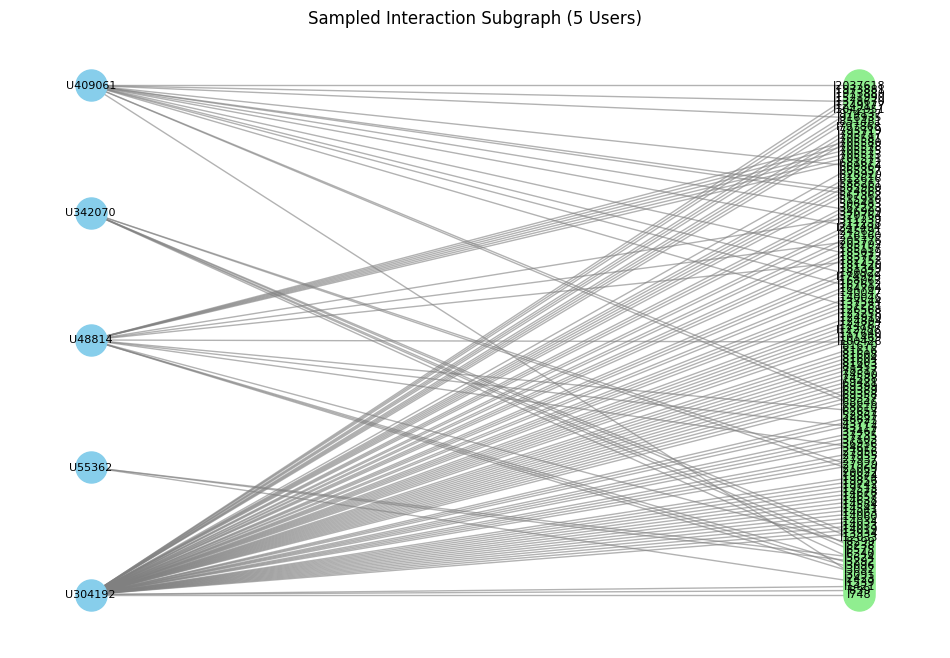

In [17]:
from src.utils.interaction_graph_visualization import visualize_sampled_interaction_subgraph

visualize_sampled_interaction_subgraph(edge_index, num_users_to_sample=5) 

## 3. Data Split - Random Interaction Split per User 

In [18]:
from src.data.split_data import split_data_per_user

train_edge_index, val_edge_index, test_edge_index = split_data_per_user(
    positive_interactions_df, 
    test_ratio=0.10, 
    val_ratio=0.10 
)

--- Starting Data Split (Target: Train=80%, Val=10%, Test=10%) ---
Input DataFrame contains 10515445 positive interactions.
Processing 429772 users for initial Train+Val/Test split...
Initial split results: 9421792 train+val interactions, 1093653 test interactions.
Processing 429772 users for Train/Validation split (target val size: 1051544)...

Final split: 8281128 train, 1140664 validation, 1093653 test interactions.
Total interactions in splits: 10515445 (Original positive: 10515445)
Split percentages: Train=78.75%, Validation=10.85%, Test=10.40%

Converting splits to edge_index tensors...
Train edge_index shape: torch.Size([2, 8281128])
Validation edge_index shape: torch.Size([2, 1140664])
Test edge_index shape: torch.Size([2, 1093653])
--- Data Split Complete ---


## 4. LightGCN Test Example

In [24]:
from src.models.lightgcn import LightGCN

# --- Hyperparameters ---
embed_dim = 64  
n_layers = 3    

n_users_total = interactions_df['user_idx'].nunique()
n_items_total = interactions_df['item_idx'].nunique()

model = LightGCN(
    n_users=n_users_total, 
    n_items=n_items_total, 
    embed_dim=embed_dim, 
    n_layers=n_layers) 

print("\nTesting Example 1: Get all embeddings...")
try:
    final_u_emb_all, final_i_emb_all = model(train_edge_index) 
    print("Successfully computed all embeddings.")
    print("Final User Embedding Shape:", final_u_emb_all.shape) 
    print("Final Item Embedding Shape:", final_i_emb_all.shape)
except NameError as e:
     print(f"Error during Example 1: A required variable (e.g., n_users, n_items, train_edge_index) might not be defined yet. {e}")
except Exception as e:
    print(f"Error during Example 1: {e}")

print("\nTesting Example 2: Get batch scores...")
try:
    users_batch = torch.tensor([0, 0, 1], dtype=torch.long) 
    pos_items_batch = torch.tensor([1, 3, 2], dtype=torch.long) 
    neg_items_batch = torch.tensor([10 % n_items_positive, 20 % n_items_positive, 30 % n_items_positive], dtype=torch.long) 
    
    pos_scores, neg_scores, _, _, _ = model(train_edge_index, users_batch, pos_items_batch, neg_items_batch)
    
    print("Successfully computed batch scores.")
    print("Example Positive Scores:", pos_scores)
    print("Example Negative Scores:", neg_scores)
except NameError as e:
     print(f"Error during Example 2: A required variable (e.g., n_items, train_edge_index) might not be defined yet. {e}")
except Exception as e:
    print(f"Error during Example 2: {e}")

Initializing LightGCN model with 3 layers...
Initialized user and item embedding layers.

Testing Example 1: Get all embeddings...
Successfully computed all embeddings.
Final User Embedding Shape: torch.Size([465323, 64])
Final Item Embedding Shape: torch.Size([2080190, 64])

Testing Example 2: Get batch scores...
Successfully computed batch scores.
Example Positive Scores: tensor([-2.5459e-06,  3.2501e-06,  1.4774e-06], grad_fn=<SumBackward1>)
Example Negative Scores: tensor([ 1.5760e-06,  4.9676e-07, -2.3414e-06], grad_fn=<SumBackward1>)


## 5. Optimizer Adam

In [25]:
import torch.optim as optim

# --- Define Optimizer Hyperparameters ---
learning_rate = 1e-3  # Common starting point, can be tuned
weight_decay = 1e-5   # L2 regularization strength (often beneficial for BPR)

print(f"Using Optimizer: Adam")
print(f"Learning Rate: {learning_rate}")
print(f"Weight Decay (L2 Regularization): {weight_decay}")

# --- Instantiate the Optimizer ---
# Pass the model's parameters to the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print("Optimizer initialized successfully.")

# You can inspect the parameter groups the optimizer is managing:
for param_group in optimizer.param_groups:
    print("Optimizer param group settings:", param_group['lr'], param_group['weight_decay'])


Using Optimizer: Adam
Learning Rate: 0.001
Weight Decay (L2 Regularization): 1e-05
Optimizer initialized successfully.
Optimizer param group settings: 0.001 1e-05


## 6. Create a User-to-Positive-Items Map

In [26]:
from collections import defaultdict

print("Creating a map from user index to their positive items in the training set...")

# Ensure train_edge_index is on CPU for this operation if it isn't already
train_edge_index_cpu = train_edge_index.cpu() 

# Use defaultdict for convenience
user_pos_items_map = defaultdict(set)

# Iterate through the training edges
for i in range(train_edge_index_cpu.shape[1]):
    user_idx = train_edge_index_cpu[0, i].item() # Get user index as Python int
    item_idx = train_edge_index_cpu[1, i].item() # Get item index as Python int
    user_pos_items_map[user_idx].add(item_idx)

print(f"Map created. Example for user 0: {len(user_pos_items_map.get(0, set()))} positive items.")
# You can check another user: print(f"User 1 positive items: {user_pos_items_map.get(1, set())}")

print("Ready for negative sampling function.")

Creating a map from user index to their positive items in the training set...
Map created. Example for user 0: 156 positive items.
Ready for negative sampling function.


## 7. Sample Negative Interaction Items

In [27]:
import random

def sample_negative_items(users_batch, n_items_total, user_pos_items_map):
    """
    Samples one negative item for each user in the batch.

    Args:
        users_batch (torch.Tensor): Tensor of user indices in the current batch.
        n_items_total (int): The total number of unique items in the dataset.
        user_pos_items_map (dict): A map from user_idx to a set of positive item_idx values 
                                   from the training set.

    Returns:
        torch.Tensor: Tensor of sampled negative item indices, same size as users_batch.
    """
    neg_items_batch = []
    users_list = users_batch.tolist() # Convert to list for easier iteration
    
    for user_idx in users_list:
        # Get the set of positive items for this user (use empty set if user has no positives in map)
        positive_items = user_pos_items_map.get(user_idx, set())
        
        while True:
            # Sample a random item index
            negative_item_idx = random.randint(0, n_items_total - 1)
            
            # Check if the sampled item is NOT in the user's positive set
            if negative_item_idx not in positive_items:
                neg_items_batch.append(negative_item_idx)
                break # Found a valid negative item, move to next user

    return torch.tensor(neg_items_batch, dtype=torch.long)

In [28]:
try:
    # Make sure users_batch, n_items_total, user_pos_items_map are defined
    neg_items_sampled = sample_negative_items(users_batch, n_items_total, user_pos_items_map)
    print("\nTesting negative sampling function:")
    print("Input users:", users_batch)
    print("Sampled negative items:", neg_items_sampled)
    # Verification check (optional):
    for i in range(len(users_batch)):
        user = users_batch[i].item()
        neg_item = neg_items_sampled[i].item()
        is_positive = neg_item in user_pos_items_map.get(user, set())
        if is_positive:
             print(f"Warning: Sampled item {neg_item} for user {user} might be positive!")
except NameError as e:
     print(f"\nError during negative sampling example: A required variable is not defined. {e}")
except Exception as e:
     print(f"\nError during negative sampling example: {e}")


Testing negative sampling function:
Input users: tensor([0, 0, 1])
Sampled negative items: tensor([1650859,  626540, 1959826])


## 8. Data Loading / Batching

In [29]:
# --- Define Batching Hyperparameters ---
batch_size = 2048 # Or 1024, 4096, etc. Adjust based on memory/performance

# Ensure train_edge_index is defined
try:
    num_train_interactions = train_edge_index.shape[1]
    num_batches = (num_train_interactions + batch_size - 1) // batch_size # Calculate number of batches needed

    print(f"Using Batch Size: {batch_size}")
    print(f"Total Training Interactions: {num_train_interactions}")
    print(f"Number of Batches per Epoch: {num_batches}")

    # --- Example: Getting the first batch for an epoch ---

    # 1. Create indices for all training interactions
    all_indices = torch.arange(num_train_interactions)

    # 2. Shuffle indices (do this ONCE per epoch)
    shuffled_indices = all_indices[torch.randperm(num_train_interactions)]
    print(f"\nIndices shuffled for the epoch. Example shuffled indices: {shuffled_indices[:10]}...")

    # 3. Select indices for the first batch
    start_idx = 0
    end_idx = min(batch_size, num_train_interactions) # Handle case where total interactions < batch_size
    batch_indices = shuffled_indices[start_idx:end_idx]

    # 4. Get the user and positive item pairs for this batch
    batch_users = train_edge_index[0, batch_indices]
    batch_pos_items = train_edge_index[1, batch_indices]

    # 5. Sample negative items for this batch
    # (Ensure n_items_total and user_pos_items_map are available, and sample_negative_items function is defined)
    try:
        batch_neg_items = sample_negative_items(batch_users, n_items_total, user_pos_items_map)
        
        print(f"\nExample first batch prepared:")
        print(f"Batch Indices Shape: {batch_indices.shape}")
        print(f"Batch Users Shape: {batch_users.shape}")
        print(f"Batch Positive Items Shape: {batch_pos_items.shape}")
        print(f"Batch Negative Items Shape: {batch_neg_items.shape}")
        print(f"Example Users: {batch_users[:5]}...")
        print(f"Example Pos Items: {batch_pos_items[:5]}...")
        print(f"Example Neg Items: {batch_neg_items[:5]}...")

    except NameError as e:
        print(f"\nError getting batch negative items: A required variable (e.g., n_items_total, user_pos_items_map, sample_negative_items) is not defined. {e}")
    except Exception as e:
         print(f"\nError getting batch negative items: {e}")

except NameError as e:
     print(f"Error: 'train_edge_index' variable not found. Ensure data splitting has been run. {e}")


Using Batch Size: 2048
Total Training Interactions: 8281128
Number of Batches per Epoch: 4044

Indices shuffled for the epoch. Example shuffled indices: tensor([7009452, 7017741, 2533682, 7588603, 4927208, 8245969, 6272542, 3630305,
        3597863, 1078183])...

Example first batch prepared:
Batch Indices Shape: torch.Size([2048])
Batch Users Shape: torch.Size([2048])
Batch Positive Items Shape: torch.Size([2048])
Batch Negative Items Shape: torch.Size([2048])
Example Users: tensor([286979, 287333,  97596, 309249, 196528])...
Example Pos Items: tensor([  20194,   58197, 1076257,  346686,   13982])...
Example Neg Items: tensor([ 116456, 1024604, 2003654, 1398093, 1896050])...


## 9.  BPR Loss

In [30]:
import torch.nn.functional as F # For the sigmoid/logsigmoid function

def calculate_bpr_loss(pos_scores, neg_scores, 
                       user_emb_initial=None, pos_item_emb_initial=None, neg_item_emb_initial=None, 
                       lambda_reg=1e-4): # Regularization strength hyperparameter
    """
    Calculates the BPR loss.

    Args:
        pos_scores (torch.Tensor): Scores for positive user-item pairs (batch_size).
        neg_scores (torch.Tensor): Scores for negative user-item pairs (batch_size).
        user_emb_initial (torch.Tensor, optional): Initial user embeddings (batch_size, embed_dim).
        pos_item_emb_initial (torch.Tensor, optional): Initial positive item embeddings (batch_size, embed_dim).
        neg_item_emb_initial (torch.Tensor, optional): Initial negative item embeddings (batch_size, embed_dim).
        lambda_reg (float, optional): L2 regularization strength. Defaults to 1e-4.

    Returns:
        torch.Tensor: The calculated BPR loss value (scalar).
    """
    
    # BPR Core Loss: -log(sigmoid(pos_score - neg_score))
    # Using F.logsigmoid(diff) is numerically more stable than log(sigmoid(diff))
    difference = pos_scores - neg_scores
    bpr_core_loss = -torch.mean(F.logsigmoid(difference)) # Mean over the batch

    # L2 Regularization Loss (if initial embeddings are provided)
    reg_loss = 0.0
    if user_emb_initial is not None and pos_item_emb_initial is not None and neg_item_emb_initial is not None:
        # Calculate L2 norm squared for each embedding type and sum
        reg_loss = (user_emb_initial.norm(2).pow(2) + 
                    pos_item_emb_initial.norm(2).pow(2) + 
                    neg_item_emb_initial.norm(2).pow(2))
        
        # Normalize by batch size (or number of users/items in batch, common practice)
        batch_size = pos_scores.shape[0] 
        reg_loss = lambda_reg * (reg_loss / batch_size) 

    # Total Loss
    total_loss = bpr_core_loss + reg_loss
    
    return total_loss

In [31]:
# --- Re-run Example 2 to get fresh outputs ---
# (Make sure model, train_edge_index, n_items_total are defined)
print("Re-running model forward pass for a batch to get inputs for loss calculation...")
try:
    # Use the same example batch
    users_batch = torch.tensor([0, 0, 1], dtype=torch.long) 
    pos_items_batch = torch.tensor([1, 3, 2], dtype=torch.long) 
    # Use the TOTAL item count for sampling negative items if not already done
    neg_items_batch = torch.tensor([10 % n_items_total, 20 % n_items_total, 30 % n_items_total], dtype=torch.long) 
    
    # Get all outputs from the forward pass
    pos_scores_test, neg_scores_test, user_emb_initial_test, \
    pos_item_emb_initial_test, neg_item_emb_initial_test = model(
        train_edge_index, users_batch, pos_items_batch, neg_items_batch
    )
    
    print("Obtained outputs from model forward pass:")
    print(" - pos_scores shape:", pos_scores_test.shape)
    print(" - neg_scores shape:", neg_scores_test.shape)
    print(" - user_emb_initial shape:", user_emb_initial_test.shape)
    print(" - pos_item_emb_initial shape:", pos_item_emb_initial_test.shape)
    print(" - neg_item_emb_initial shape:", neg_item_emb_initial_test.shape)
    
    inputs_ready = True

except NameError as e:
    print(f"Error getting model outputs: A required variable is not defined. {e}")
    inputs_ready = False
except Exception as e:
    print(f"Error getting model outputs: {e}")
    inputs_ready = False

# --- Test the calculate_bpr_loss function ---
if inputs_ready:
    print("\nTesting calculate_bpr_loss function...")
    try:
        # Define regularization strength (can be the same as optimizer's weight_decay or different)
        lambda_reg_test = 1e-5 

        loss = calculate_bpr_loss(
            pos_scores=pos_scores_test, 
            neg_scores=neg_scores_test, 
            user_emb_initial=user_emb_initial_test, 
            pos_item_emb_initial=pos_item_emb_initial_test, 
            neg_item_emb_initial=neg_item_emb_initial_test, 
            lambda_reg=lambda_reg_test
        )

        print(f"Successfully calculated BPR loss with lambda_reg={lambda_reg_test}")
        print(f"Calculated Loss: {loss.item()}") # .item() gets the scalar value
        print(f"Loss Tensor Type: {loss.dtype}")
        print(f"Loss Tensor Shape: {loss.shape}") # Should be torch.Size([]) for a scalar

        # Basic sanity check (loss should generally be positive)
        if loss.item() < 0:
             print("Warning: Calculated loss is negative, which is unusual for BPR.")
             
    except Exception as e:
        print(f"Error during BPR loss calculation test: {e}")
else:
    print("\nSkipping BPR loss test because model outputs could not be obtained.")

Re-running model forward pass for a batch to get inputs for loss calculation...
Obtained outputs from model forward pass:
 - pos_scores shape: torch.Size([3])
 - neg_scores shape: torch.Size([3])
 - user_emb_initial shape: torch.Size([3, 64])
 - pos_item_emb_initial shape: torch.Size([3, 64])
 - neg_item_emb_initial shape: torch.Size([3, 64])

Testing calculate_bpr_loss function...
Successfully calculated BPR loss with lambda_reg=1e-05
Calculated Loss: 0.6931467652320862
Loss Tensor Type: torch.float32
Loss Tensor Shape: torch.Size([])


## 10. Training

In [40]:
import torch
import torch.optim as optim
import time # To time epochs
# Removed: from tqdm.notebook import tqdm 

# --- Training Hyperparameters ---
epochs = 10 # Number of training epochs (can adjust)

# Other hyperparameters (batch_size, learning_rate, weight_decay, lambda_reg) are assumed to be defined
print_every_n_batches = 1 # How often to print progress update

# --- Setup ---
# Make sure these are defined:
# model, optimizer, train_edge_index, calculate_bpr_loss, 
# sample_negative_items, user_pos_items_map, n_items_total, batch_size, weight_decay

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)
train_edge_index = train_edge_index.to(device) 

# --- Training Loop ---
print("\n--- Starting Training ---")
print(f"Training for 10 epochs\n4044 batches each\nbatch size: {batch_size}\nprint_every_n_batches: {print_every_n_batches}")
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

for epoch in range(1, epochs + 1):
    start_time = time.time()
    model.train() # Set model to training mode
    
    total_loss = 0.0
    
    # Shuffle training data indices for this epoch
    num_train_interactions = train_edge_index.shape[1]
    all_indices = torch.arange(num_train_interactions).to(device) 
    shuffled_indices = all_indices[torch.randperm(num_train_interactions)]
    
    num_batches = (num_train_interactions + batch_size - 1) // batch_size
    
    print(f"--- Starting Epoch {epoch}/{epochs} ---") # Indicate epoch start

    # --- Iterate through batches ---
    for i in range(num_batches):
        # --- Batch Preparation ---
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_train_interactions)
        batch_indices = shuffled_indices[start_idx:end_idx]

        batch_users = train_edge_index[0, batch_indices]
        batch_pos_items = train_edge_index[1, batch_indices]

        # Sample negative items
        batch_neg_items = sample_negative_items(batch_users.cpu(), n_items_total, user_pos_items_map).to(device)
        
        # --- Forward and Backward Pass ---
        optimizer.zero_grad() 
        
        pos_scores, neg_scores, user_emb_initial, \
        pos_item_emb_initial, neg_item_emb_initial = model(
            train_edge_index, 
            batch_users, 
            batch_pos_items, 
            batch_neg_items
        )
        
        loss = calculate_bpr_loss( 
            pos_scores, neg_scores,
            user_emb_initial, pos_item_emb_initial, neg_item_emb_initial,
            lambda_reg=weight_decay 
        )
        
        loss.backward()
        optimizer.step()
        
        # --- Logging ---
        total_loss += loss.item()
        
        # --- Print Progress Update ---
        # Print every N batches or on the last batch
        if (i + 1) % print_every_n_batches == 0 or (i + 1) == num_batches:
             # Use \r to move cursor to beginning of line, overwriting previous update
             # Add spaces at the end to clear previous longer messages
             print(f"\rEpoch {epoch}/{epochs} | Batch {i+1}/{num_batches} | Current Loss: {loss.item():.4f}   ", end='')

    # --- Epoch End ---
    print() # Move to the next line after the epoch's batch updates are done
    epoch_duration = time.time() - start_time
    avg_loss = total_loss / num_batches
    print(f"--- Epoch {epoch}/{epochs} Finished | Average Loss: {avg_loss:.4f} | Duration: {epoch_duration:.2f}s ---")

print("\n--- Training Finished ---")

Using device: cpu

--- Starting Training ---
Training for 10 epochs
4044 batches each
batch size: 2048
print_every_n_batches: 1
Total trainable parameters: 162,916,928
--- Starting Epoch 1/10 ---
Epoch 1/10 | Batch 55/4044 | Current Loss: 0.6931   

KeyboardInterrupt: 